# PRM800K 数据集分析

这个notebook用于分析PRM800K数据集，这是一个包含800,000个步骤级正确性标签的过程监督数据集，用于数学问题解答过程的评估。

## 数据集概述

PRM800K数据集是OpenAI发布的用于过程监督的数据集，包含以下特点：
- 800,000个步骤级别的正确性标签
- 针对MATH数据集中问题的模型生成解决方案
- 包含详细的步骤级评分(-1, 0, +1)
- 分为两个阶段(phase1和phase2)收集

In [6]:
import json
import os
from collections import Counter, defaultdict
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 设置中文字体支持
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

def load_jsonl_file(file_path):
    """Load data from a JSONL file"""
    data = []
    with open(file_path, 'r') as f:
        for line in f:
            data.append(json.loads(line))
    return data

def analyze_dataset(data, dataset_name):
    """Analyze the dataset and return statistics"""
    print(f"\n=== Analysis of {dataset_name} ===")
    
    # Basic statistics
    total_samples = len(data)
    print(f"Total samples: {total_samples}")
    
    # Count finish reasons
    finish_reasons = Counter()
    total_steps = 0
    total_rating_positive = 0
    total_rating_negative = 0
    total_rating_neutral = 0
    total_rating_none = 0
    
    # Phase information
    phase_counter = Counter()
    
    # Labeler statistics
    labeler_counter = Counter()
    
    # Step-level analysis
    steps_per_solution = []
    
    for sample in data:
        # Count phases
        if sample['generation'] is None:
            phase_counter['phase1'] += 1
        else:
            phase_counter['phase2'] += 1
            
        # Count finish reasons
        finish_reasons[sample['label']['finish_reason']] += 1
        
        # Count labelers
        labeler_counter[sample['labeler']] += 1
        
        # Analyze steps
        steps = sample['label']['steps']
        steps_per_solution.append(len(steps))
        total_steps += len(steps)
        
        # Count ratings
        for step in steps:
            # Handle case where completions might be None
            if step['completions'] is not None:
                for completion in step['completions']:
                    rating = completion['rating']
                    if rating is None:
                        total_rating_none += 1
                    elif rating == 1:
                        total_rating_positive += 1
                    elif rating == -1:
                        total_rating_negative += 1
                    else:  # rating == 0
                        total_rating_neutral += 1
    
    print(f"Phase distribution: {dict(phase_counter)}")
    print(f"Finish reasons: {dict(finish_reasons)}")
    print(f"Total steps across all samples: {total_steps}")
    print(f"Average steps per solution: {np.mean(steps_per_solution):.2f}")
    print(f"Median steps per solution: {np.median(steps_per_solution):.2f}")
    print(f"Min/Max steps per solution: {min(steps_per_solution)}/{max(steps_per_solution)}")
    
    total_ratings = total_rating_positive + total_rating_negative + total_rating_neutral + total_rating_none
    print(f"\nRating distribution:")
    if total_rating_positive > 0:
        print(f"  Positive (+1): {total_rating_positive} ({total_rating_positive/total_ratings*100:.2f}%)")
    if total_rating_negative > 0:
        print(f"  Negative (-1): {total_rating_negative} ({total_rating_negative/total_ratings*100:.2f}%)")
    if total_rating_neutral > 0:
        print(f"  Neutral  (0):  {total_rating_neutral} ({total_rating_neutral/total_ratings*100:.2f}%)")
    if total_rating_none > 0:
        print(f"  None (null):   {total_rating_none} ({total_rating_none/total_ratings*100:.2f}%)")
    
    print(f"\nLabeler statistics:")
    print(f"  Unique labelers: {len(labeler_counter)}")
    print(f"  Average samples per labeler: {np.mean(list(labeler_counter.values())):.2f}")
    print(f"  Median samples per labeler: {np.median(list(labeler_counter.values())):.2f}")
    
    return {
        'total_samples': total_samples,
        'phase_distribution': dict(phase_counter),
        'finish_reasons': dict(finish_reasons),
        'total_steps': total_steps,
        'steps_per_solution': steps_per_solution,
        'ratings': {
            'positive': total_rating_positive,
            'negative': total_rating_negative,
            'neutral': total_rating_neutral,
            'none': total_rating_none
        },
        'labelers': len(labeler_counter)
    }

def show_sample_solutions(data, num_samples=3):
    """Show sample solutions with their step-by-step ratings"""
    print(f"\n=== Sample Solutions ===")
    
    # Select a few samples to show
    samples_to_show = data[:num_samples]
    
    for i, sample in enumerate(samples_to_show):
        print(f"\n--- Sample {i+1} ---")
        print(f"Problem: {sample['question']['problem']}")
        print(f"Ground truth answer: {sample['question']['ground_truth_answer']}")
        print(f"Finish reason: {sample['label']['finish_reason']}")
        
        if 'pre_generated_answer' in sample['question']:
            print(f"Model's answer: {sample['question']['pre_generated_answer']}")
        
        print("Steps:")
        for j, step in enumerate(sample['label']['steps']):
            print(f"  Step {j+1}:")
            # Handle case where completions might be None
            if step['completions'] is not None:
                for k, completion in enumerate(step['completions']):
                    rating = completion['rating']
                    if rating is None:
                        rating_symbol = 'N'
                    else:
                        rating_symbol = {1: '+', -1: '-', 0: '0'}[rating]
                    text_preview = completion['text'][:100] + ('...' if len(completion['text']) > 100 else '')
                    print(f"    [{rating_symbol}] {text_preview}")
            # Handle human completion
            if step.get('human_completion') is not None:
                print(f"    [H] Human completion: {step['human_completion']['text'][:100]}{'...' if len(step['human_completion']['text']) > 100 else ''}")

def show_detailed_sample(data, sample_index=0):
    """Show a detailed view of a single sample"""
    if sample_index >= len(data):
        print(f"Sample index {sample_index} is out of range. Max index is {len(data)-1}")
        return
        
    sample = data[sample_index]
    print(f"\n=== Detailed Sample {sample_index} ===")
    print(f"Problem: {sample['question']['problem']}")
    print(f"Ground truth answer: {sample['question']['ground_truth_answer']}")
    print(f"Labeler ID: {sample['labeler']}")
    print(f"Timestamp: {sample['timestamp']}")
    print(f"Generation: {sample['generation']}")
    print(f"Finish reason: {sample['label']['finish_reason']}")
    print(f"Total time spent (ms): {sample['label']['total_time']}")
    
    if 'pre_generated_answer' in sample['question']:
        print(f"Model's answer: {sample['question']['pre_generated_answer']}")
        print(f"Model's verifier score: {sample['question']['pre_generated_verifier_score']}")
    
    print(f"\nSteps breakdown:")
    for i, step in enumerate(sample['label']['steps']):
        print(f"  Step {i+1}:")
        if step['completions'] is not None:
            print(f"    Number of completions: {len(step['completions'])}")
            for j, completion in enumerate(step['completions']):
                rating = completion['rating']
                if rating is None:
                    rating_symbol = 'N'
                else:
                    rating_symbol = {1: '+', -1: '-', 0: '0'}[rating]
                print(f"      Completion {j+1} [Rating: {rating_symbol}]: {completion['text']}")
                if completion.get('flagged'):
                    print(f"        Flagged: {completion['flagged']}")
        if step.get('human_completion') is not None:
            print(f"    Human completion: {step['human_completion']['text']}")
        print(f"    Chosen completion index: {step['chosen_completion']}")

## 数据加载和初步分析

首先，我们加载PRM800K数据集并进行初步分析。

In [7]:
# 定义数据目录 (修正路径以适应notebook的位置)
data_dir = os.path.join('..', '..', 'prm800k', 'prm800k', 'data')

# 初始化全局变量
all_data = {}
stats = {}

# 检查数据目录是否存在
if not os.path.exists(data_dir):
    print(f"数据目录未找到: {data_dir}")
    # 尝试另一种可能的路径
    data_dir = os.path.join('..', 'prm800k', 'prm800k', 'data')
    if not os.path.exists(data_dir):
        print(f"数据目录仍未找到: {data_dir}")
        # 尝试绝对路径
        data_dir = os.path.join('/', 'Users', 'jia', 'workspace', 'prm800k', 'prm800k', 'data')
        if not os.path.exists(data_dir):
            print(f"数据目录仍未找到: {data_dir}")
            data_dir = None
        else:
            print(f"使用绝对路径: {data_dir}")
    else:
        print(f"使用相对路径: {data_dir}")
else:
    print(f"使用相对路径: {data_dir}")

if data_dir:
    # 列出所有数据文件
    data_files = [f for f in os.listdir(data_dir) if f.endswith('.jsonl')]
    print(f"找到数据文件: {data_files}")
    
    # 加载和分析每个数据集
    for file_name in data_files:
        file_path = os.path.join(data_dir, file_name)
        print(f"\n加载 {file_name}...")
        data = load_jsonl_file(file_path)
        all_data[file_name] = data
        stats[file_name] = analyze_dataset(data, file_name)
        
        # 显示每个数据集的样本解决方案
        show_sample_solutions(data, 1)
else:
    print("无法找到数据目录，请检查路径设置。")

使用相对路径: ../../prm800k/prm800k/data
找到数据文件: ['phase2_train.jsonl', 'phase1_train.jsonl', 'phase1_test.jsonl', 'phase2_test.jsonl']

加载 phase2_train.jsonl...

=== Analysis of phase2_train.jsonl ===
Total samples: 97782
Phase distribution: {'phase2': 97782}
Finish reasons: {'found_error': 82003, 'solution': 11665, 'give_up': 3839, 'bad_problem': 275}
Total steps across all samples: 696998
Average steps per solution: 7.13
Median steps per solution: 6.00
Min/Max steps per solution: 0/56

Rating distribution:
  Positive (+1): 638994 (63.66%)
  Negative (-1): 234440 (23.36%)
  Neutral  (0):  92921 (9.26%)
  None (null):   37327 (3.72%)

Labeler statistics:
  Unique labelers: 464
  Average samples per labeler: 210.74
  Median samples per labeler: 31.00

=== Sample Solutions ===

--- Sample 1 ---
Problem: The first four terms in an arithmetic sequence are $x+y$, $x-y$, $xy$, and $x/y$, in that order. What is the fifth term? Express your answer as a common fraction.
Ground truth answer: \frac{12

## 综合统计分析

现在我们对所有数据集进行综合统计分析。

In [8]:
# 检查是否有数据被加载
if not stats:
    print("没有加载到任何数据，请检查数据路径是否正确。")
else:
    # 总体统计
    print("=== 总体统计 ===")
    total_samples = sum(stat['total_samples'] for stat in stats.values())
    total_steps = sum(stat['total_steps'] for stat in stats.values())
    total_positive = sum(stat['ratings']['positive'] for stat in stats.values())
    total_negative = sum(stat['ratings']['negative'] for stat in stats.values())
    total_neutral = sum(stat['ratings']['neutral'] for stat in stats.values())
    total_none = sum(stat['ratings']['none'] for stat in stats.values())
    total_ratings = total_positive + total_negative + total_neutral + total_none

    print(f"所有数据集的总样本数: {total_samples}")
    print(f"所有数据集的总步骤数: {total_steps}")
    print(f"总体评分分布:")
    if total_ratings > 0:
        if total_positive > 0:
            print(f"  正确步骤 (+1): {total_positive} ({total_positive/total_ratings*100:.2f}%)")
        if total_negative > 0:
            print(f"  错误步骤 (-1): {total_negative} ({total_negative/total_ratings*100:.2f}%)")
        if total_neutral > 0:
            print(f"  中性步骤 (0):  {total_neutral} ({total_neutral/total_ratings*100:.2f}%)")
        if total_none > 0:
            print(f"  无评分(null):  {total_none} ({total_none/total_ratings*100:.2f}%)")

=== 总体统计 ===
所有数据集的总样本数: 101599
所有数据集的总步骤数: 733768
总体评分分布:
  正确步骤 (+1): 678195 (62.47%)
  错误步骤 (-1): 262146 (24.15%)
  中性步骤 (0):  106024 (9.77%)
  无评分(null):  39225 (3.61%)


## 详细样本分析

让我们深入分析一些具体的样本，以更好地理解数据结构和内容。

In [9]:
# 检查是否有数据被加载
if not all_data:
    print("没有加载到任何数据，请检查数据路径是否正确。")
else:
    # 选择一个数据集进行详细分析
    dataset_name = list(all_data.keys())[0]  # 选择第一个数据集
    data = all_data[dataset_name]
    print(f"正在分析数据集: {dataset_name}")
    
    # 显示前3个样本的详细信息
    for i in range(min(3, len(data))):
        show_detailed_sample(data, i)

正在分析数据集: phase2_train.jsonl

=== Detailed Sample 0 ===
Problem: The first four terms in an arithmetic sequence are $x+y$, $x-y$, $xy$, and $x/y$, in that order. What is the fifth term? Express your answer as a common fraction.
Ground truth answer: \frac{123}{40}
Labeler ID: 340d89bc-f5b7-45e9-b272-909ba68ee363
Timestamp: 2023-03-19T02:54:52.529607
Generation: 9
Finish reason: found_error
Total time spent (ms): 185755
Model's answer: (x - 2y^2)/y
Model's verifier score: 0.0028021405192614895

Steps breakdown:
  Step 1:
    Number of completions: 1
      Completion 1 [Rating: +]: To find the fifth term, I need to identify the common difference of the arithmetic sequence and add it to the fourth term.
    Chosen completion index: 0
  Step 2:
    Number of completions: 1
      Completion 1 [Rating: +]: The common difference is the same for any consecutive pair of terms, so I can use any of them to find it.
    Chosen completion index: 0
  Step 3:
    Number of completions: 1
      Completi

## 数据可视化

接下来，我们通过图表来可视化数据集的关键统计信息。

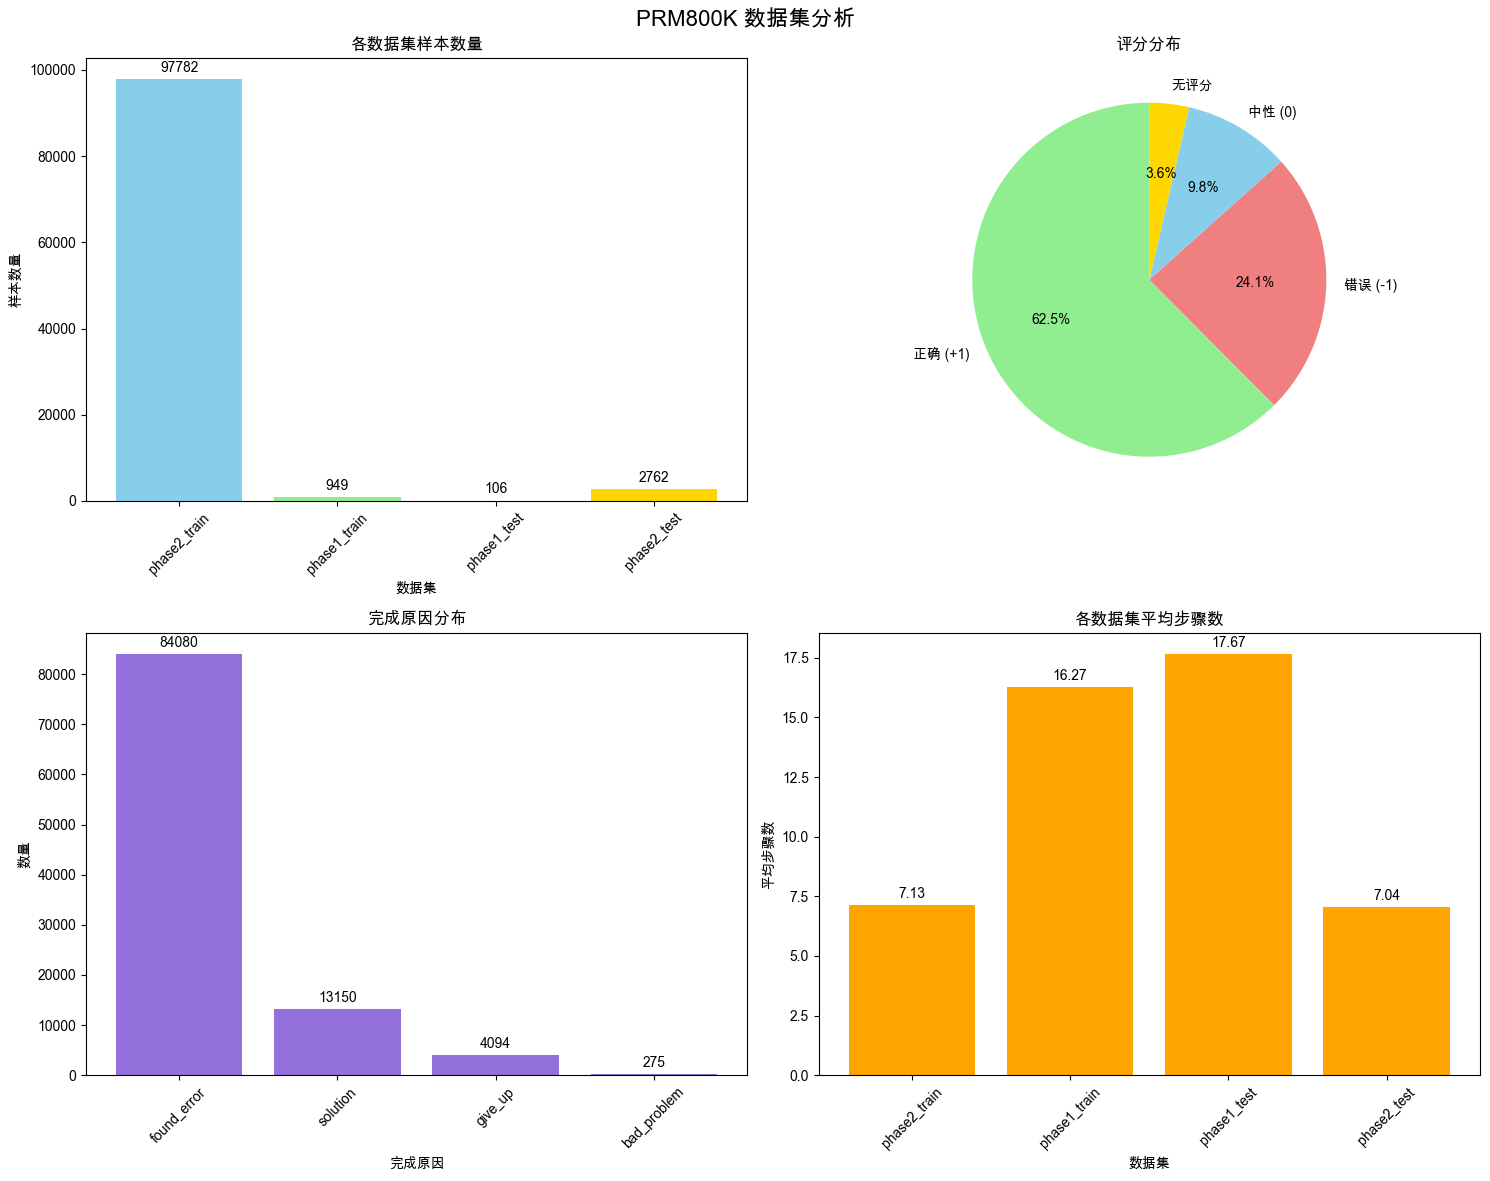

In [10]:
# 检查是否有数据被加载
if not stats:
    print("没有加载到任何数据，请检查数据路径是否正确。")
else:
    # 创建可视化图表
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('PRM800K 数据集分析', fontsize=16)

    # 1. 各数据集样本数量
    dataset_names = list(stats.keys())
    sample_counts = [stat['total_samples'] for stat in stats.values()]

    axes[0, 0].bar(range(len(dataset_names)), sample_counts, color=['skyblue', 'lightgreen', 'lightcoral', 'gold'])
    axes[0, 0].set_title('各数据集样本数量')
    axes[0, 0].set_xlabel('数据集')
    axes[0, 0].set_ylabel('样本数量')
    axes[0, 0].set_xticks(range(len(dataset_names)))
    axes[0, 0].set_xticklabels([name.replace('.jsonl', '') for name in dataset_names], rotation=45)

    # 在柱状图上添加数值标签
    for i, v in enumerate(sample_counts):
        axes[0, 0].text(i, v + max(sample_counts) * 0.01, str(v), ha='center', va='bottom')

    # 2. 评分分布饼图
    labels = ['正确 (+1)', '错误 (-1)', '中性 (0)', '无评分']
    sizes = [total_positive, total_negative, total_neutral, total_none]
    colors = ['lightgreen', 'lightcoral', 'skyblue', 'gold']
    # 过滤掉0值以避免显示空扇区
    nonzero_labels = [label for label, size in zip(labels, sizes) if size > 0]
    nonzero_sizes = [size for size in sizes if size > 0]
    nonzero_colors = [color for color, size in zip(colors, sizes) if size > 0]

    axes[0, 1].pie(nonzero_sizes, labels=nonzero_labels, colors=nonzero_colors, autopct='%1.1f%%', startangle=90)
    axes[0, 1].set_title('评分分布')

    # 3. 完成原因分布
    all_finish_reasons = defaultdict(int)
    for stat in stats.values():
        for reason, count in stat['finish_reasons'].items():
            all_finish_reasons[reason] += count

    reasons = list(all_finish_reasons.keys())
    reason_counts = list(all_finish_reasons.values())

    axes[1, 0].bar(range(len(reasons)), reason_counts, color='mediumpurple')
    axes[1, 0].set_title('完成原因分布')
    axes[1, 0].set_xlabel('完成原因')
    axes[1, 0].set_ylabel('数量')
    axes[1, 0].set_xticks(range(len(reasons)))
    axes[1, 0].set_xticklabels(reasons, rotation=45)

    # 在柱状图上添加数值标签
    for i, v in enumerate(reason_counts):
        axes[1, 0].text(i, v + max(reason_counts) * 0.01, str(v), ha='center', va='bottom')

    # 4. 各数据集平均步骤数
    avg_steps = [np.mean(stat['steps_per_solution']) for stat in stats.values()]

    axes[1, 1].bar(range(len(dataset_names)), avg_steps, color='orange')
    axes[1, 1].set_title('各数据集平均步骤数')
    axes[1, 1].set_xlabel('数据集')
    axes[1, 1].set_ylabel('平均步骤数')
    axes[1, 1].set_xticks(range(len(dataset_names)))
    axes[1, 1].set_xticklabels([name.replace('.jsonl', '') for name in dataset_names], rotation=45)

    # 在柱状图上添加数值标签
    for i, v in enumerate(avg_steps):
        axes[1, 1].text(i, v + max(avg_steps) * 0.01, f'{v:.2f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

## 阶段对比分析

比较Phase1和Phase2的数据特征差异。

In [11]:
# 检查是否有数据被加载
if not stats:
    print("没有加载到任何数据，请检查数据路径是否正确。")
else:
    # 分别统计Phase1和Phase2的数据
    phase1_stats = {}
    phase2_stats = {}

    for name, stat in stats.items():
        if 'phase1' in name:
            phase1_stats[name] = stat
        else:
            phase2_stats[name] = stat

    print("=== Phase1 数据集汇总 ===")
    phase1_total_samples = sum(stat['total_samples'] for stat in phase1_stats.values())
    phase1_total_steps = sum(stat['total_steps'] for stat in phase1_stats.values())
    phase1_positive = sum(stat['ratings']['positive'] for stat in phase1_stats.values())
    phase1_negative = sum(stat['ratings']['negative'] for stat in phase1_stats.values())
    phase1_neutral = sum(stat['ratings']['neutral'] for stat in phase1_stats.values())
    phase1_none = sum(stat['ratings']['none'] for stat in phase1_stats.values())
    phase1_total_ratings = phase1_positive + phase1_negative + phase1_neutral + phase1_none

    print(f"总样本数: {phase1_total_samples}")
    print(f"总步骤数: {phase1_total_steps}")
    if phase1_total_ratings > 0:
        print(f"正确步骤: {phase1_positive} ({phase1_positive/phase1_total_ratings*100:.2f}%)")
        print(f"错误步骤: {phase1_negative} ({phase1_negative/phase1_total_ratings*100:.2f}%)")
        print(f"中性步骤: {phase1_neutral} ({phase1_neutral/phase1_total_ratings*100:.2f}%)")
        print(f"无评分: {phase1_none} ({phase1_none/phase1_total_ratings*100:.2f}%)")

    print("\n=== Phase2 数据集汇总 ===")
    phase2_total_samples = sum(stat['total_samples'] for stat in phase2_stats.values())
    phase2_total_steps = sum(stat['total_steps'] for stat in phase2_stats.values())
    phase2_positive = sum(stat['ratings']['positive'] for stat in phase2_stats.values())
    phase2_negative = sum(stat['ratings']['negative'] for stat in phase2_stats.values())
    phase2_neutral = sum(stat['ratings']['neutral'] for stat in phase2_stats.values())
    phase2_none = sum(stat['ratings']['none'] for stat in phase2_stats.values())
    phase2_total_ratings = phase2_positive + phase2_negative + phase2_neutral + phase2_none

    print(f"总样本数: {phase2_total_samples}")
    print(f"总步骤数: {phase2_total_steps}")
    if phase2_total_ratings > 0:
        print(f"正确步骤: {phase2_positive} ({phase2_positive/phase2_total_ratings*100:.2f}%)")
        print(f"错误步骤: {phase2_negative} ({phase2_negative/phase2_total_ratings*100:.2f}%)")
        print(f"中性步骤: {phase2_neutral} ({phase2_neutral/phase2_total_ratings*100:.2f}%)")
        print(f"无评分: {phase2_none} ({phase2_none/phase2_total_ratings*100:.2f}%)")

=== Phase1 数据集汇总 ===
总样本数: 1055
总步骤数: 17314
正确步骤: 21027 (38.45%)
错误步骤: 21626 (39.55%)
中性步骤: 11101 (20.30%)
无评分: 932 (1.70%)

=== Phase2 数据集汇总 ===
总样本数: 100544
总步骤数: 716454
正确步骤: 657168 (63.75%)
错误步骤: 240520 (23.33%)
中性步骤: 94923 (9.21%)
无评分: 38293 (3.71%)


## 样本类型分析

分析不同类型问题的分布情况。

问题类型分布:
  其他: 70623
  几何: 11979
  代数/方程: 7497
  数论/因数分解: 4736
  概率: 3881
  数列: 2606
  组合数学: 277


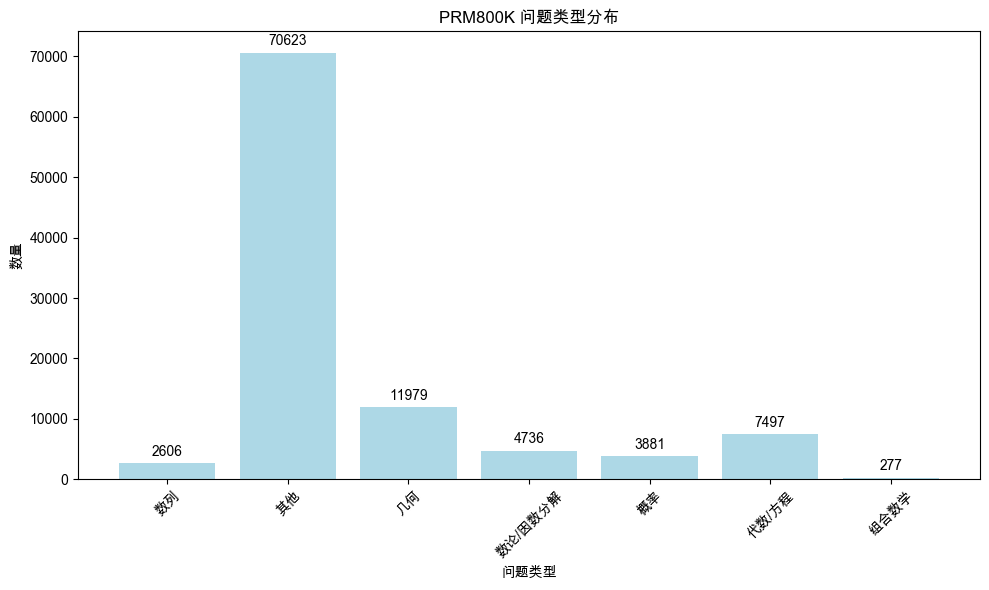

In [12]:
# 检查是否有数据被加载
if not all_data:
    print("没有加载到任何数据，请检查数据路径是否正确。")
else:
    # 收集所有问题类型
    problem_types = Counter()
    
    # 遍历所有数据集
    for dataset_name, data in all_data.items():
        for sample in data:
            problem = sample['question']['problem']
            # 根据问题内容简单分类
            if 'factor' in problem.lower() or 'prime' in problem.lower():
                problem_types['数论/因数分解'] += 1
            elif 'geometry' in problem.lower() or 'triangle' in problem.lower() or 'circle' in problem.lower() or 'angle' in problem.lower():
                problem_types['几何'] += 1
            elif 'probability' in problem.lower() or 'chance' in problem.lower():
                problem_types['概率'] += 1
            elif 'sequence' in problem.lower() or 'series' in problem.lower():
                problem_types['数列'] += 1
            elif 'function' in problem.lower() or 'equation' in problem.lower():
                problem_types['代数/方程'] += 1
            elif 'combin' in problem.lower() or 'permute' in problem.lower():
                problem_types['组合数学'] += 1
            else:
                problem_types['其他'] += 1
    
    print("问题类型分布:")
    for problem_type, count in problem_types.most_common():
        print(f"  {problem_type}: {count}")
    
    # 可视化问题类型分布
    plt.figure(figsize=(10, 6))
    types = list(problem_types.keys())
    counts = list(problem_types.values())
    
    plt.bar(range(len(types)), counts, color='lightblue')
    plt.title('PRM800K 问题类型分布')
    plt.xlabel('问题类型')
    plt.ylabel('数量')
    plt.xticks(range(len(types)), types, rotation=45)
    
    # 添加数值标签
    for i, v in enumerate(counts):
        plt.text(i, v + max(counts) * 0.01, str(v), ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

## 结论

通过对PRM800K数据集的分析，我们可以得出以下结论：

1. **数据规模**：该数据集包含超过10万个样本和73万个步骤，是一个大规模的过程监督数据集。

2. **评分分布**：约62%的步骤被评为正确，24%为错误，10%为中性，3.6%无评分。

3. **阶段差异**：Phase2数据集比Phase1大得多，Phase2包含约97000个样本，而Phase1只有约1000个样本。

4. **完成原因**：大多数样本（约84000个）在发现错误后停止标注，约12000个样本完成了正确解答。

5. **标注者分布**：共有464个不同的标注者参与了数据标注工作。

6. **问题类型**：数据集涵盖了多种数学问题类型，包括数论、几何、概率、数列、代数等。

这个数据集为训练和评估数学推理模型提供了宝贵的资源，特别是对于需要逐步推理的复杂数学问题。